In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/resnet50/imagenet_class_index.json
/kaggle/input/aptos2019-blindness-detection/sample_submission.csv
/kaggle/input/aptos2019-blindness-detection/train.csv
/kaggle/input/aptos2019-blindness-detection/test.csv
/kaggle/input/aptos2019-blindness-detection/train_images/ef476be214d4.png
/kaggle/input/aptos2019-blindness-detection/train_images/6dcde47060f9.png
/kaggle/input/aptos2019-blindness-detection/train_images/ec363f48867b.png
/kaggle/input/aptos2019-blindness-detection/train_images/17f6c7072f61.png
/kaggle/input/aptos2019-blindness-detection/train_images/b49b2fac2514.png
/kaggle/input/aptos2019-blindness-detection/train_images/af6166d57f13.png
/kaggle/input/aptos2019-blindness-detection/train_images/8d13c46e7d75.png
/kaggle/input/aptos2019-blindness-detection/train_images/c3b15bf9b4bc.png
/kaggle/input/aptos2019-blindness-detect

In [2]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

2024-02-28 10:01:24.182174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 10:01:24.182299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 10:01:24.306761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [4]:
# EDA Part and Data Overview
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


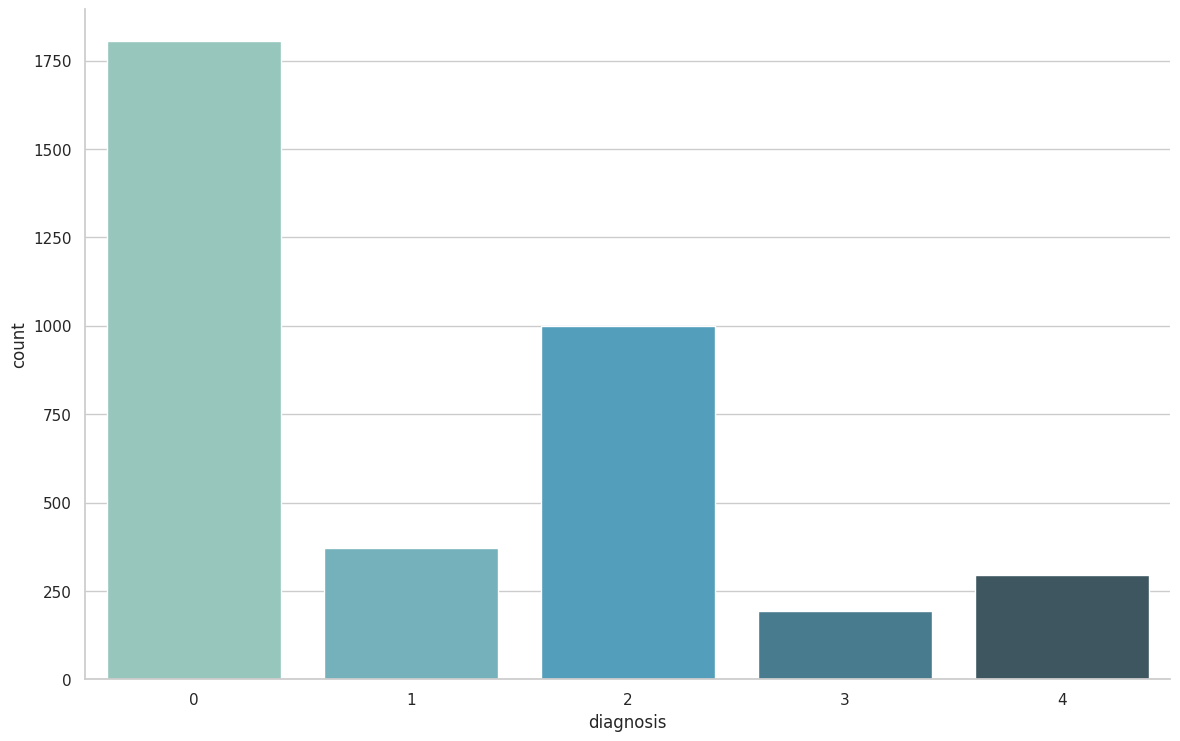

In [5]:
# Label Class Distribution
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

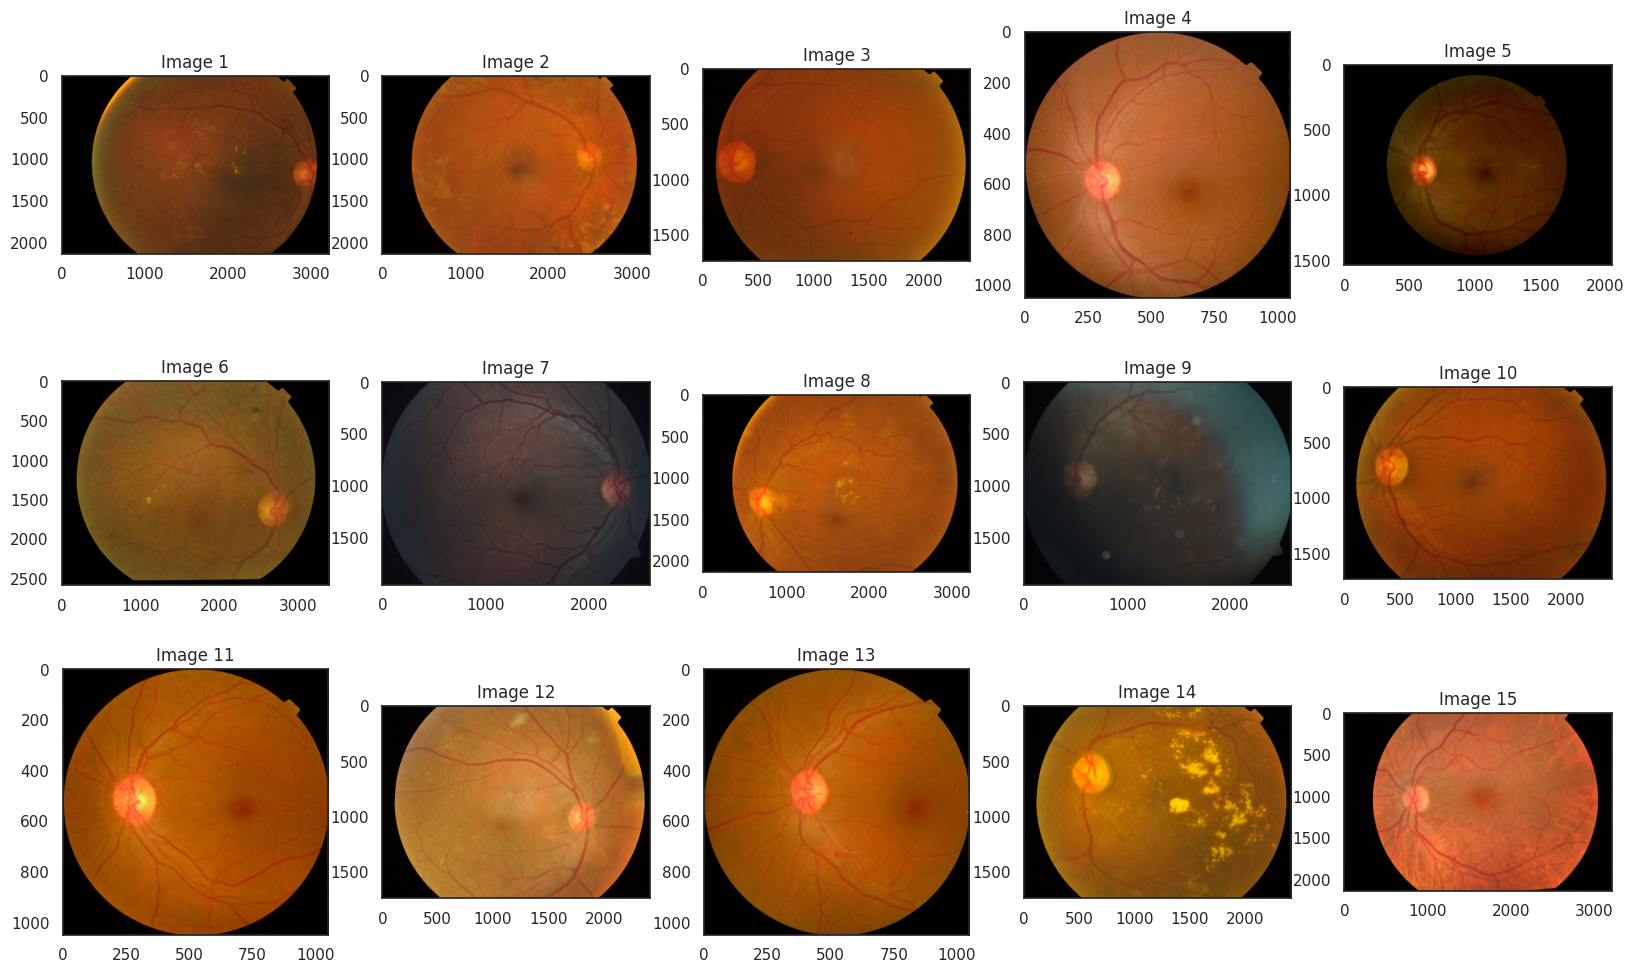

In [6]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("../input/aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [7]:
# Setting the model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [8]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [9]:
# Data Generator for train, test and validation
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [10]:
from tensorflow.keras import applications, optimizers
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights='imagenet', 
                                       include_top=False,
                                       input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [11]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

# Freeze all layers and then unfreeze the last 5
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

# Learning rate warm-up
metric_list = ["accuracy"]
WARMUP_LEARNING_RATE = 1e-4
optimizer = optimizers.Adam(learning_rate=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=metric_list)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 128, 128,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 128, 128,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 128, 128,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_3_c

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 4,206,597 (16.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
import os

os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'

In [13]:
# Train the top layers of the model
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=WARMUP_EPOCHS,
    verbose=1
).history

Epoch 1/2
  1/366 ━━━━━━━━━━━━━━━━━━━━ 3:03:43 30s/step - accuracy: 0.2500 - loss: 3.6048

I0000 00:00:1709114548.600856      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709114548.652085      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


151/366 ━━━━━━━━━━━━━━━━━━━━ 3:55 1s/step - accuracy: 0.3534 - loss: 2.4596

W0000 00:00:1709114712.806477      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3570 - loss: 2.3469

W0000 00:00:1709114934.845301      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/366 ━━━━━━━━━━━━━━━━━━━━ 519s 1s/step - accuracy: 0.3570 - loss: 2.3464 - val_accuracy: 0.4615 - val_loss: 1.3162
Epoch 2/2
366/366 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.2500 - loss: 2.0368 - val_accuracy: 0.2500 - val_loss: 0.9927


In [14]:
# Finetune the complete model
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 518, 518,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 256, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 256, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 256, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 258, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 128, 128,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 128, 128,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 128, 128,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 128, 128,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 128, 128,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 128, 128,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 128, 128,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 128, 128,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 128, 128,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 128, 128,  │      1,024 │ conv2_block1_3_c

 Total params: 27,794,309 (106.03 MB)

 Trainable params: 27,741,189 (105.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
history_finetuning = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=EPOCHS,
    callbacks=callback_list,
    verbose=1
).history

Epoch 1/20


W0000 00:00:1709115132.829903      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/366 ━━━━━━━━━━━━━━━━━━━━ 52s 966ms/step - accuracy: 0.6779 - loss: 0.3259

W0000 00:00:1709115433.422359      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.6854 - loss: 0.3172

W0000 00:00:1709115482.784726      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


366/366 ━━━━━━━━━━━━━━━━━━━━ 521s 1s/step - accuracy: 0.6855 - loss: 0.3171 - val_accuracy: 0.4602 - val_loss: 0.4550 - learning_rate: 1.0000e-04
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8750 - loss: 0.1652 - val_accuracy: 0.5000 - val_loss: 0.5093 - learning_rate: 1.0000e-04
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.7840 - loss: 0.2045 - val_accuracy: 0.6854 - val_loss: 0.3476 - learning_rate: 1.0000e-04
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.8750 - loss: 0.1019 - val_accuracy: 0.7500 - val_loss: 0.2175 - learning_rate: 1.0000e-04
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.8187 - loss: 0.1754 - val_accuracy: 0.7761 - val_loss: 0.2211 - learning_rate: 1.0000e-04
Epoch 6/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - accuracy: 0.7500 - loss: 0.1639 - val_accuracy: 1.0000 - val_loss: 0.0631 - learning_rate: 1.0000e-04
Epoch 7/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.8

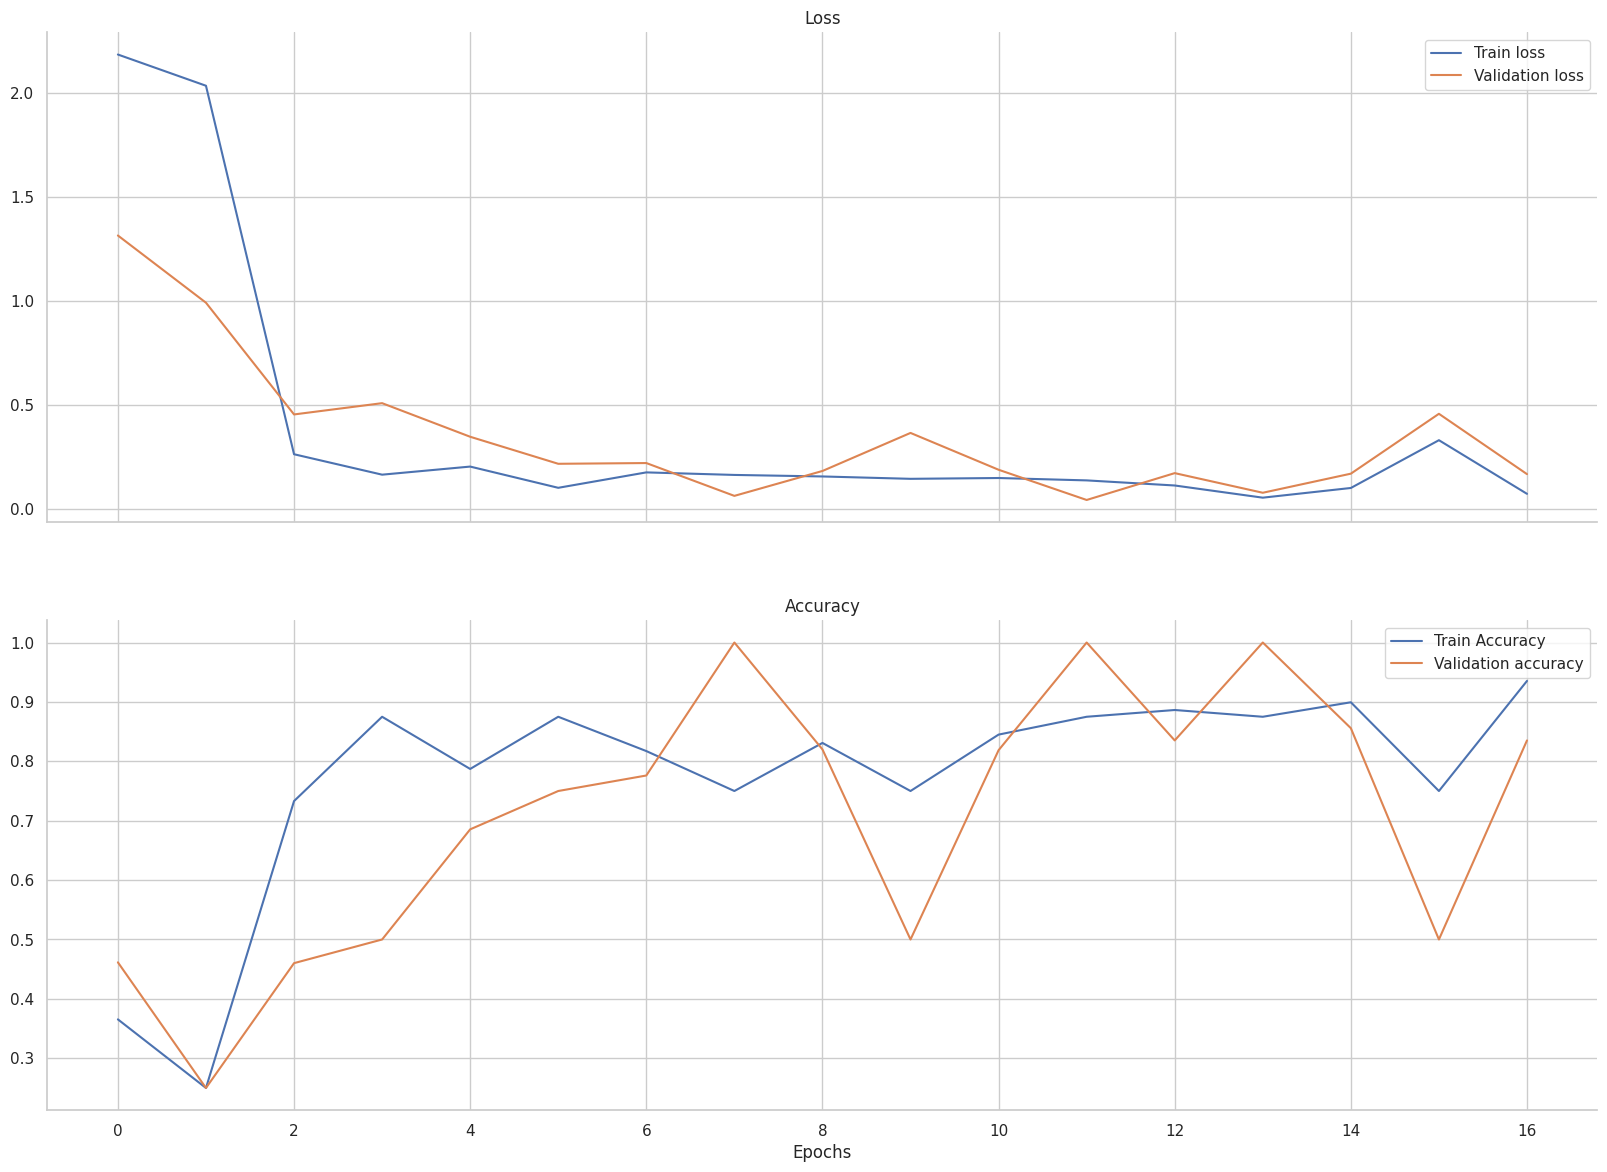

In [16]:
# Model loss graph
history = {
    'loss': history_warmup['loss'] + history_finetuning['loss'],
    'val_loss': history_warmup['val_loss'] + history_finetuning['val_loss'],
    'accuracy': history_warmup['accuracy'] + history_finetuning['accuracy'],
    'val_accuracy': history_warmup['val_accuracy'] + history_finetuning['val_accuracy']
}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train Accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [17]:
# Model Evaluation
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.
3662/3662 ━━━━━━━━━━━━━━━━━━━━ 399s 107ms/step


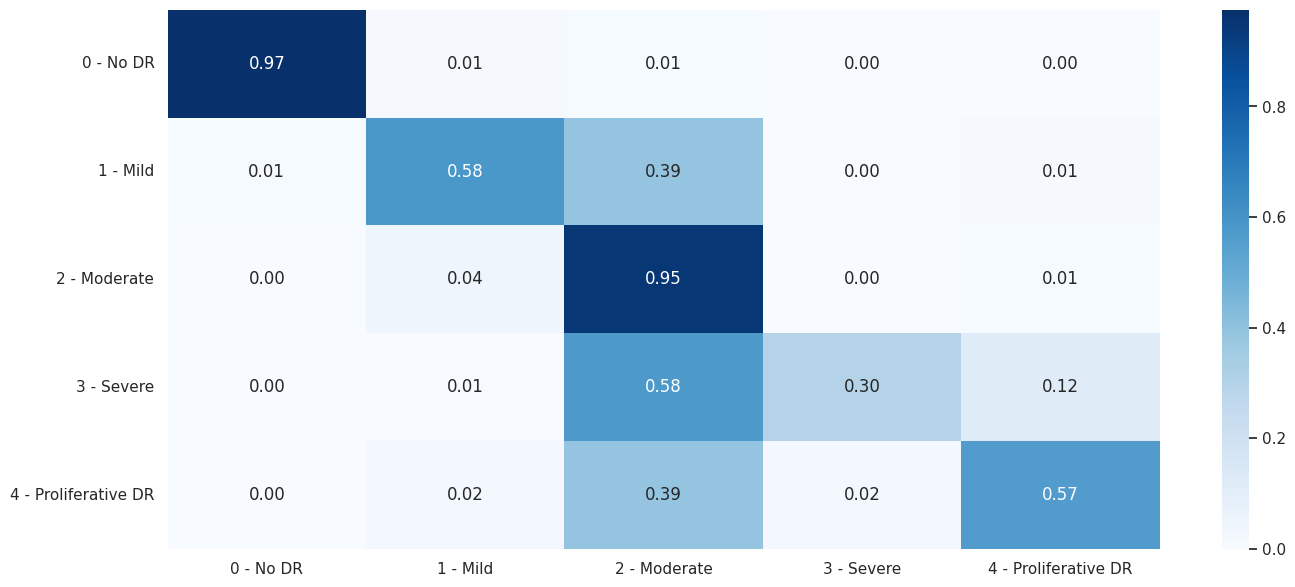

In [18]:
# Confusion Matrix
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [19]:
# Finding the Quadratic Kappa Score
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.907


In [20]:
# Apply the model to test set and output predictions
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

1928/1928 ━━━━━━━━━━━━━━━━━━━━ 107s 56ms/step


In [21]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,2


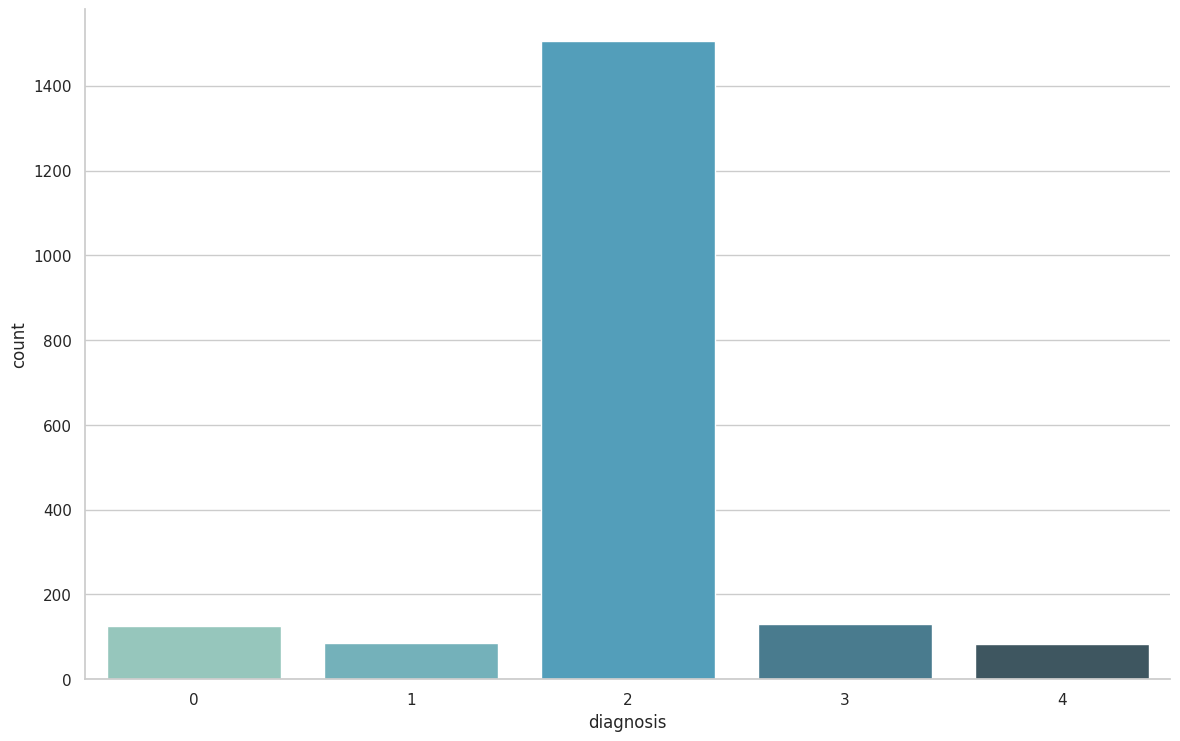

In [22]:
# Predictions class distribution
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [23]:
# Save the model
model.save('diabetic_retinopathy_model.h5')

In [24]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [25]:
# Load the saved model
loaded_model = load_model('diabetic_retinopathy_model.h5')

In [26]:
# Path to the test image you want to predict
test_image_path = "/kaggle/input/aptos2019-blindness-detection/train_images/000c1434d8d7.png"

In [27]:
# Load and preprocess the test image
img = image.load_img(test_image_path, target_size=(HEIGHT, WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

In [28]:
# Make predictions
predictions = loaded_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [29]:
# Convert predictions to the corresponding class
predicted_class = np.argmax(predictions)
print("Predicted Diabetic Retinopathy Stage:", predicted_class)

Predicted Diabetic Retinopathy Stage: 2
